# <h1 align="center"><strong>Final - Yelp and Trip Advisor Sentiment Analysis</strong></h1>


In [1]:
#Importing all libraries necessary

import pandas as pd
import numpy as np
import spacy
import torch
from spacytextblob.spacytextblob import SpacyTextBlob
import gspread
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import pipeline
import re
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
from plotly.subplots import make_subplots

import warnings 
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

pd.set_option('display.max_columns', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
import nltk
import re
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter

In [2]:
#Loading Data sets

df = pd.read_excel("yelp_reviews.xlsx")
df1 = pd.read_excel("tripadvisor_reviews.xlsx")

## Compare ratings between Yelp and TripAdvisor

### Comparision using side by side bar charts

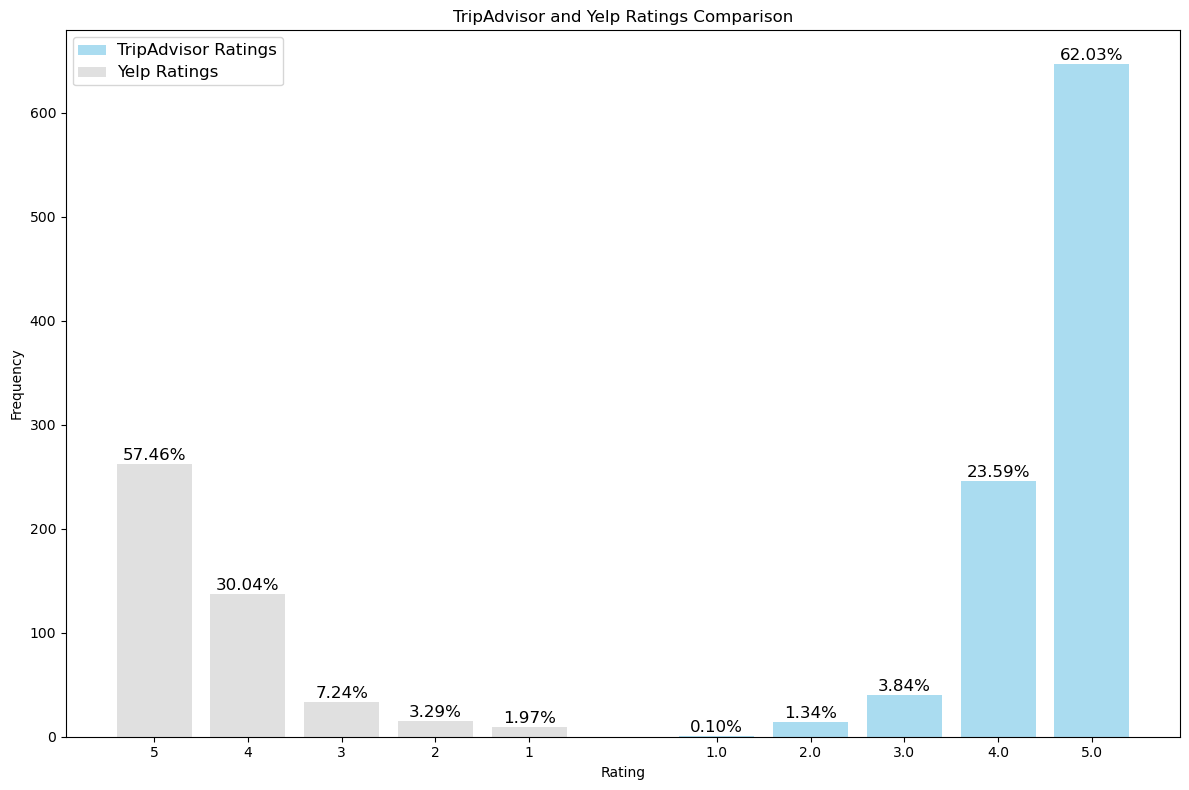

In [3]:
# Extract relevant columns
df_ratings = df['ratings']
df1_ratings = df1['Ratings']

# Convert ratings to numeric (assuming they are strings)
df_ratings = pd.to_numeric(df_ratings, errors='coerce')
df1_ratings = pd.to_numeric(df1_ratings, errors='coerce')

# Create a single plot with TripAdvisor ratings on top and Yelp ratings on the negative side
fig, ax = plt.subplots(figsize=(12, 8))

# Plot TripAdvisor ratings on top
df1_ratings_counts = df1_ratings.value_counts().sort_index()
ax.bar(df1_ratings_counts.index, df1_ratings_counts, color='skyblue', alpha=0.7, label='TripAdvisor Ratings')

# Plot Yelp ratings on the negative side
df_ratings_counts = df_ratings.value_counts().sort_index()
ax.bar(-df_ratings_counts.index, df_ratings_counts, color='lightgray', alpha=0.7, label='Yelp Ratings')

# Display percentages on top of each bar
for i, (v_tripadvisor, v_yelp) in enumerate(zip(df1_ratings_counts, df_ratings_counts)):
    ax.text(i + 1, v_tripadvisor + 1, f"{(v_tripadvisor / len(df1_ratings)):.2%}", ha='center', va='bottom', fontsize=12, color='black')
    ax.text(-(i + 1), v_yelp + 1, f"{(v_yelp / len(df_ratings)):.2%}", ha='center', va='bottom', fontsize=12, color='black')

# Set x-axis labels
ax.set_xticks(list(range(1, len(df1_ratings_counts) + 1)) + [-i for i in range(1, len(df_ratings_counts) + 1)])
ax.set_xticklabels(list(df1_ratings_counts.index) + list(df_ratings_counts.index))

# Set title and labels
ax.set_title('TripAdvisor and Yelp Ratings Comparison')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')

# Add legend with bigger font size and black color
legend = ax.legend()
for text in legend.get_texts():
    text.set_color('black')
    text.set_fontsize(12)  # Adjust the font size as needed

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()


## Yelp - line chart reviews by year 

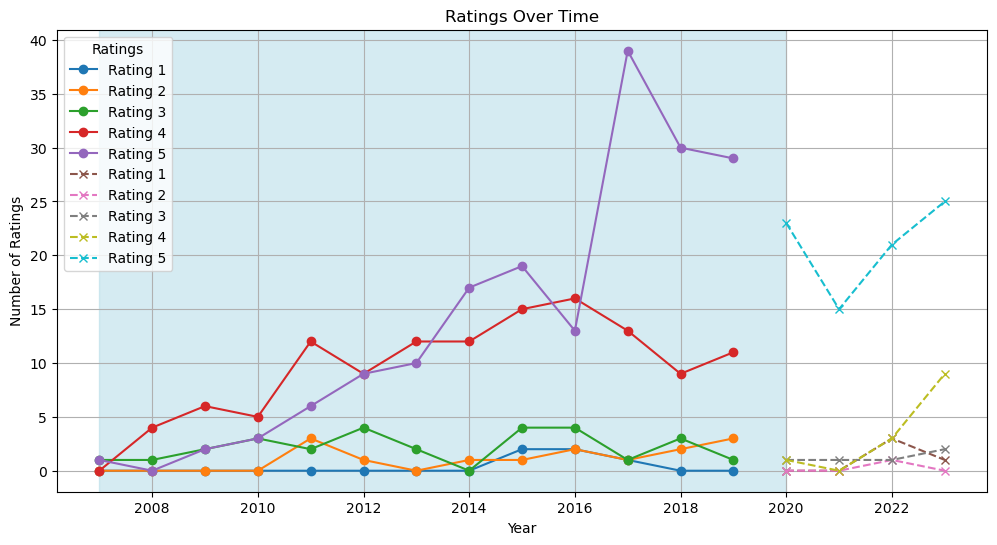

In [4]:
# Convert the 'review_date' column to a datetime object
df['review_date'] = pd.to_datetime(df['review_date'])

# Extract the year and month from the 'review_date' column
df['year'] = df['review_date'].dt.year

# Create a pivot table to count ratings for each year and rating category
rating_counts = df.pivot_table(index='year', columns='ratings', values='name', aggfunc='count', fill_value=0)

# Separate the data before and after February 2020
before_feb_2020 = rating_counts[rating_counts.index < 2020]
after_feb_2020 = rating_counts[rating_counts.index >= 2020]

# Create a line chart with different background colors
plt.figure(figsize=(12, 6))

# Background color for the period before February 2020
plt.axvspan(before_feb_2020.index.min(), 2020, color='lightblue', alpha=0.5)

# Plot five different lines for each rating category
for rating in range(1, 6):
    plt.plot(before_feb_2020.index, before_feb_2020[rating], label=f'Rating {rating}', marker='o')

for rating in range(1, 6):
    plt.plot(after_feb_2020.index, after_feb_2020[rating], label=f'Rating {rating}', linestyle='--', marker='x')

plt.title('Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.legend(title='Ratings')
plt.grid(True)
plt.show()


## Compare distributions for Vadar and Roberta

### Vader (NLTK Model)

SentimentIntensityAnalyzer is a component of NLTK used specifically for sentiment analysis. It is based on a technique known as VADER (Valence Aware Dictionary and sEntiment Reasoner), which is particularly well-suited for analyzing sentiments expressed in social media contexts (like tweets or comments), movie reviews, or similar texts. VADER combines a dictionary of lexical features (which are labeled according to their semantic orientation as either positive or negative) with rules that encode grammatical and syntactical conventions for expressing sentiment.

<strong>Usage and Outcome</strong>

The SentimentIntensityAnalyzer provides a method polarity_scores that accepts a string and returns a dictionary with four entries:
    
    'neg': Negative sentiment score.
    'neu': Neutral sentiment score.
    'pos': Positive sentiment score.
    'compound': An aggregated score that combines the positive, negative, and neutral scores. This score ranges from -1 (extremely negative) to +1 (extremely positive).
    
<strong>Variables, Input, and Output </strong>

In the context of the provided code snippet:

Variables:
sia: An instance of the SentimentIntensityAnalyzer.
Input:
The input to sia.polarity_scores is typically a string (like a sentence, a tweet, a review text, etc.) for which you want to analyze the sentiment.
Output:
The output is a dictionary containing the scores ('neg', 'neu', 'pos', and 'compound') indicating the sentiment of the input text.
Significance

The significance of using SentimentIntensityAnalyzer is to automatically determine the emotional tone behind words in a text. This is useful in several areas such as understanding customer sentiment in reviews, gauging public opinion in social media, analyzing survey responses, etc. The compound score, in particular, gives a single measure of the overall sentiment of the text, simplifying tasks like categorizing texts as either positive, negative, or neutral based on their sentiment.

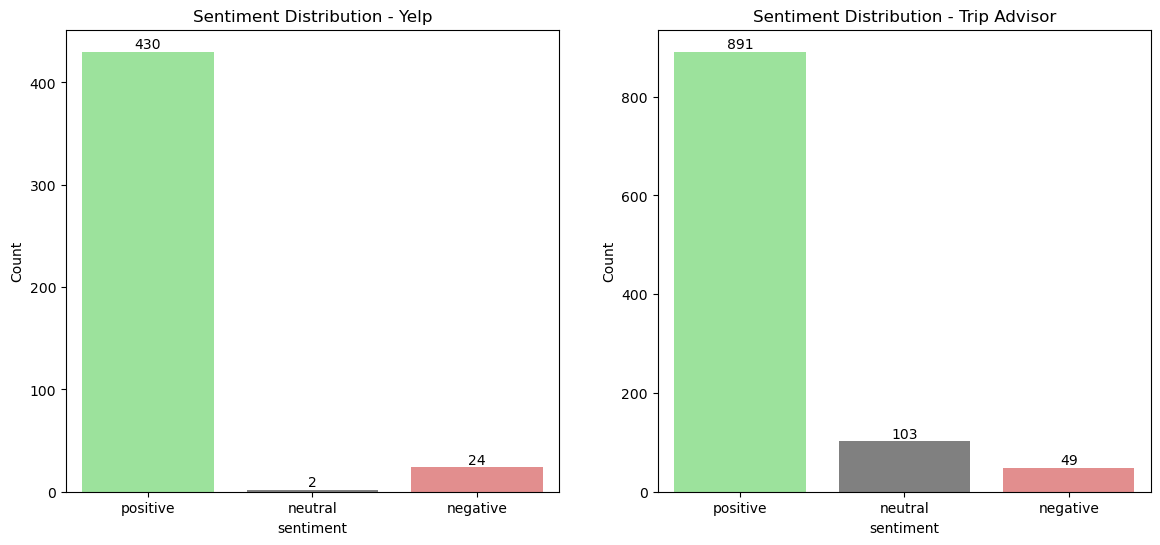

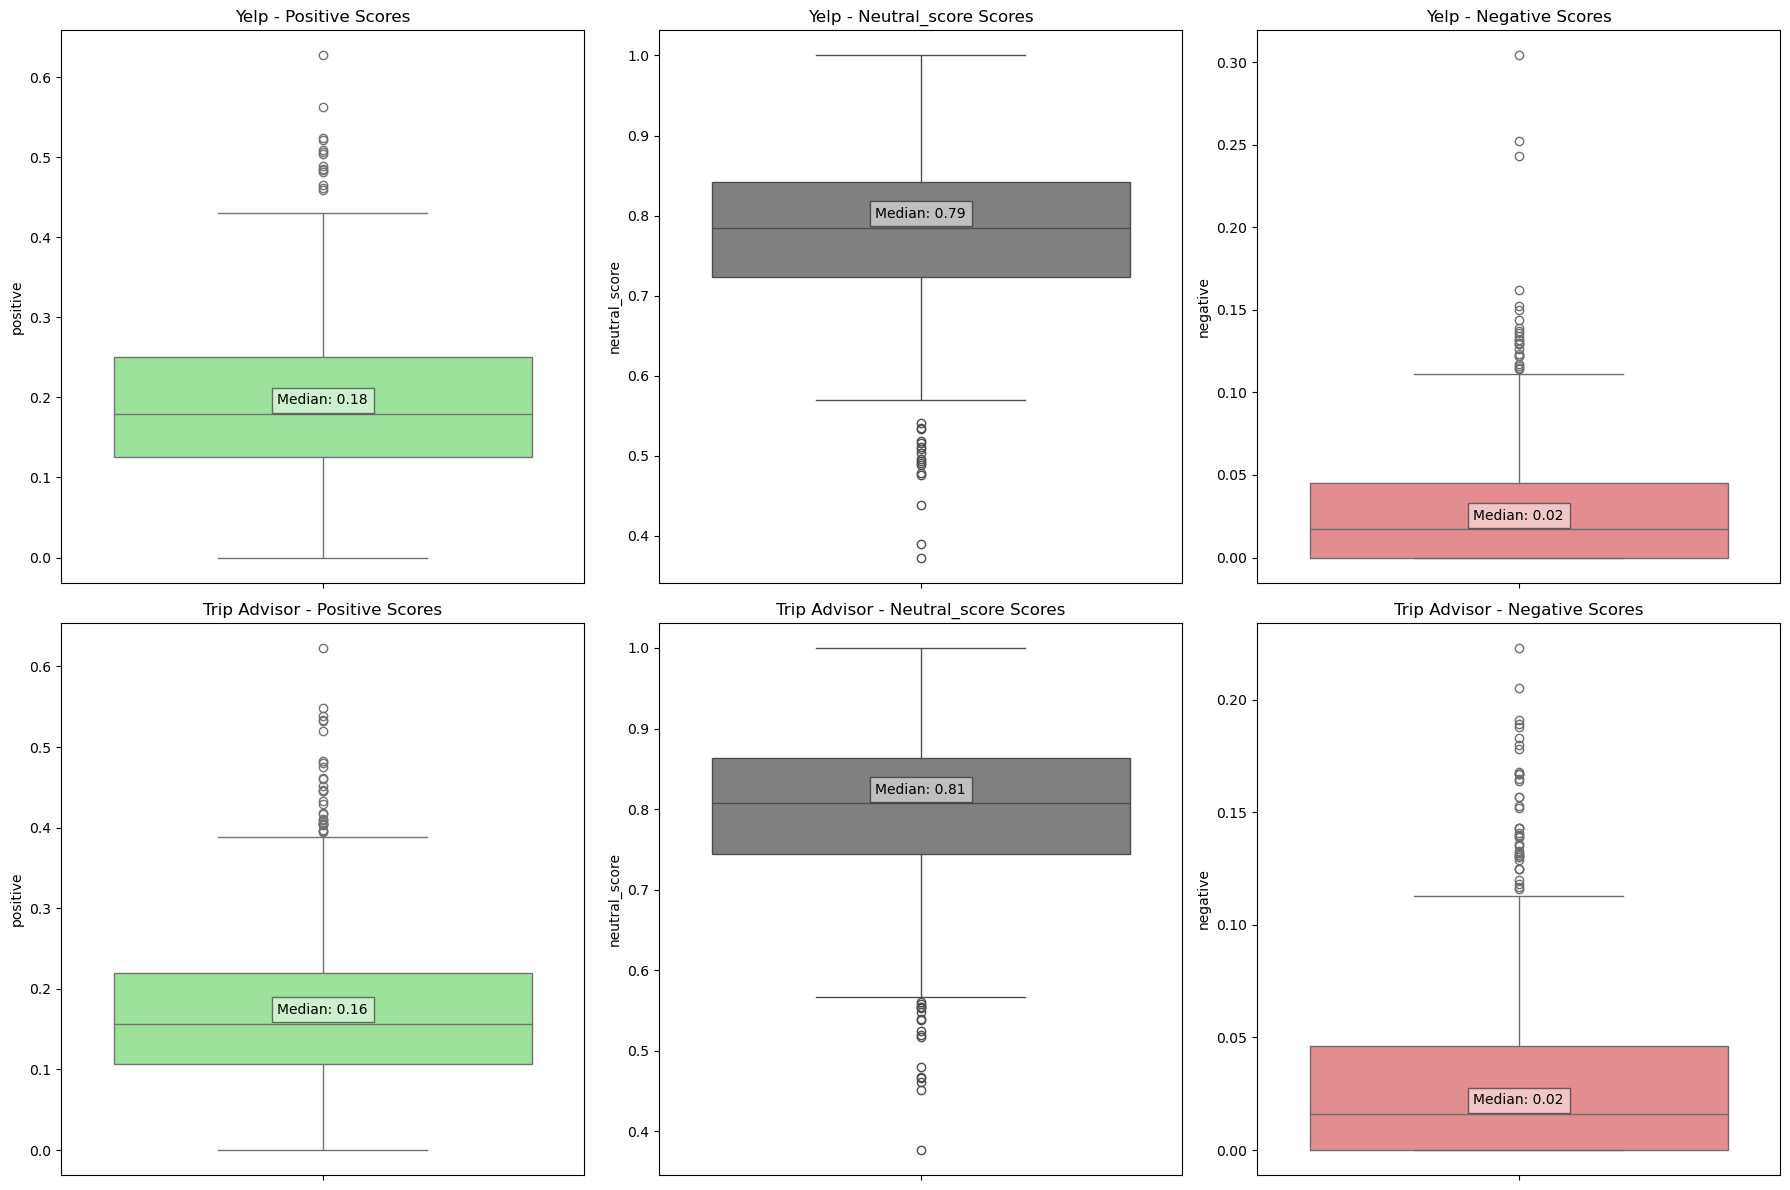

In [5]:
# Sentiment analysis using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment(data, text_column):
    sia = SentimentIntensityAnalyzer()
    data['compound'] = data[text_column].apply(lambda x: sia.polarity_scores(str(x))['compound'] if pd.notnull(x) else 0)
    data['sentiment'] = data['compound'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
    data['positive'] = data[text_column].apply(lambda x: sia.polarity_scores(str(x))['pos'] if pd.notnull(x) else 0)
    data['neutral_score'] = data[text_column].apply(lambda x: sia.polarity_scores(str(x))['neu'] if pd.notnull(x) else 0)
    data['negative'] = data[text_column].apply(lambda x: sia.polarity_scores(str(x))['neg'] if pd.notnull(x) else 0)

analyze_sentiment(df, 'comment')
analyze_sentiment(df1, 'Content')

# Function to add labels to the bar chart
def add_bar_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Function to annotate box plots
def add_boxplot_labels(ax, data, column):
    for i in range(len(data[column].unique())):
        median = data[column].median()
        ax.annotate(f'Median: {median:.2f}', xy=(i, median), xytext=(0, 10), 
                    textcoords='offset points', ha='center', va='center', 
                    fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5))

# Define the order for the plots
sentiment_order = ['positive', 'neutral', 'negative']

# Plot bar chart for sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for df
sns.countplot(x='sentiment', data=df, order=sentiment_order, palette={'positive': 'lightgreen', 'neutral': 'gray', 'negative': 'lightcoral'}, ax=axes[0])
axes[0].set_title('Sentiment Distribution - Yelp')
axes[0].set_ylabel('Count')
add_bar_labels(axes[0])

# Bar chart for df1
sns.countplot(x='sentiment', data=df1, order=sentiment_order, palette={'positive': 'lightgreen', 'neutral': 'gray', 'negative': 'lightcoral'}, ax=axes[1])
axes[1].set_title('Sentiment Distribution - Trip Advisor')
axes[1].set_ylabel('Count')
add_bar_labels(axes[1])

plt.show()

# Plot boxplot for individual sentiment score distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Box plot for individual scores in df
for i, sentiment in enumerate(['positive', 'neutral_score', 'negative']):
    sns.boxplot(y=sentiment, data=df, color='lightgreen' if sentiment == 'positive' else 'gray' if sentiment == 'neutral_score' else 'lightcoral', ax=axes[0, i])
    axes[0, i].set_title(f'Yelp - {sentiment.capitalize()} Scores')
    add_boxplot_labels(axes[0, i], df, sentiment)

# Box plot for individual scores in df1
for i, sentiment in enumerate(['positive', 'neutral_score', 'negative']):
    sns.boxplot(y=sentiment, data=df1, color='lightgreen' if sentiment == 'positive' else 'gray' if sentiment == 'neutral_score' else 'lightcoral', ax=axes[1, i])
    axes[1, i].set_title(f'Trip Advisor - {sentiment.capitalize()} Scores')
    add_boxplot_labels(axes[1, i], df1, sentiment)

plt.tight_layout()
plt.show()


### Hugging Face

Hugging Face is a company specializing in Natural Language Processing (NLP) technology and is particularly renowned for its work with Transformer-based models like BERT, GPT, and others. They provide an open-source library, often also referred to as "Hugging Face", which is widely used in the AI community for a variety of NLP tasks including text classification, information extraction, question answering, and sentiment analysis.

<strong>Outcome of Hugging Face Models in Sentiment Analysis</strong>:

When using Hugging Face models for sentiment analysis, the outcome typically includes:

1. Sentiment Classification: The model classifies the sentiment of a given text into categories such as 'positive', 'neutral', and 'negative'. This is useful for understanding the emotional tone or opinion expressed in the text.

2. Confidence Scores: Along with the classification, these models often provide confidence scores indicating how certain the model is about its prediction. These scores can be used to gauge the reliability of the classification.

**Variables, Input, and Output in Sentiment Analysis**:

- Variables:
  - Model: The specific pre-trained model used for sentiment analysis (e.g., BERT, DistilBERT).
  - Tokenizer: A component that processes the input text to make it suitable for analysis by the model (e.g., splitting into tokens, adding special tokens).

- Input:
  - Text Data: The input to the model, which is the text for which you want to analyze the sentiment. This can be in the form of tweets, reviews, comments, or any text.

- Output:
  - Sentiment Label: The predicted sentiment category (e.g., 'positive', 'neutral', 'negative').
  - Confidence Score: A numerical score representing the model's confidence in its sentiment prediction. Higher scores indicate greater confidence.
  
**BERT and RoBERTa: Language Models for Understanding Text**

BERT (Bidirectional Encoder Representations from Transformers) and RoBERTa (A Robustly Optimized BERT Pretraining Approach) are both powerful language models based on the transformer architecture, widely used for natural language processing (NLP) tasks like sentiment analysis, text classification, and question answering. While they share similarities, there are some key differences:

  **Similarities:**

Transformer-based: Both employ transformers, which are neural networks that use self-attention to process text by considering the relationships between words in a sentence. This allows them to capture more complex context compared to earlier NLP models.
Pre-trained: Both are pre-trained on massive amounts of text data, allowing them to learn general language representations that can be fine-tuned for specific tasks.
Hugging Face availability: Both are available in the Hugging Face library, providing easy access and implementation.
Differences:

Pre-training objectives: BERT uses two objectives: masked language modeling (MLM) and next sentence prediction (NSP). RoBERTa removes NSP and focuses solely on MLM, leading to potentially more robust representations.
Training data: RoBERTa uses larger mini-batches and longer training sequences compared to BERT, potentially improving performance.
Vocabulary size: RoBERTa uses byte-pair encoding, resulting in a larger vocabulary (50k vs. 30k in BERT) that may better capture rare words.
Fine-tuning: Both can be fine-tuned for specific tasks, but RoBERTa often shows better performance out-of-the-box, requiring less fine-tuning.

**Significance in Sentiment Analysis**:

- Business Insights: Sentiment analysis helps businesses understand customer opinions and feedback.
- Social Media Monitoring: It’s used to gauge public opinion on various topics over social media.
- Market Research: Understanding sentiments can be crucial in market research and campaign analysis.


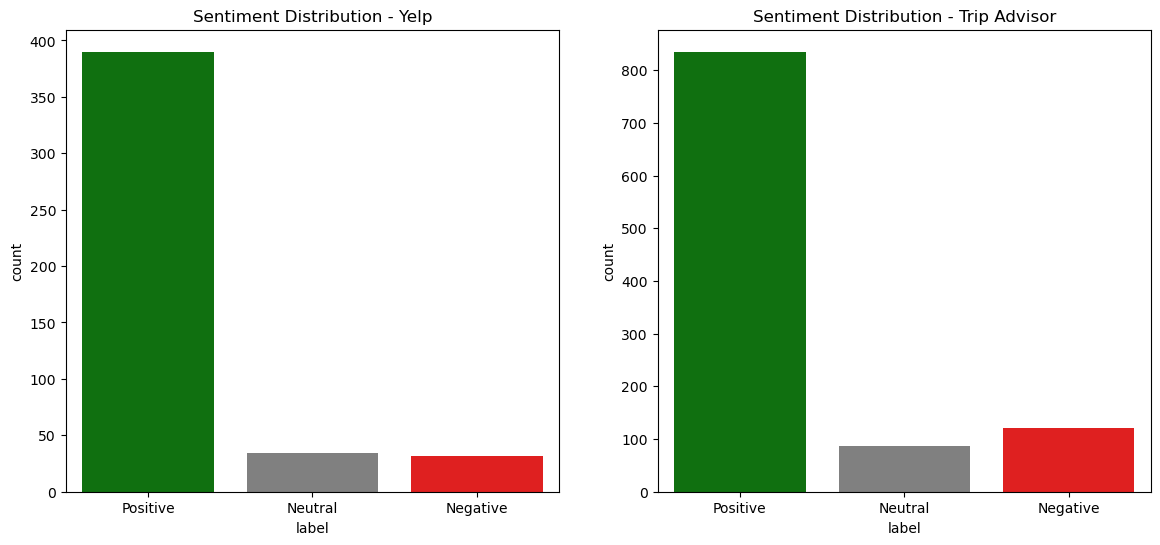

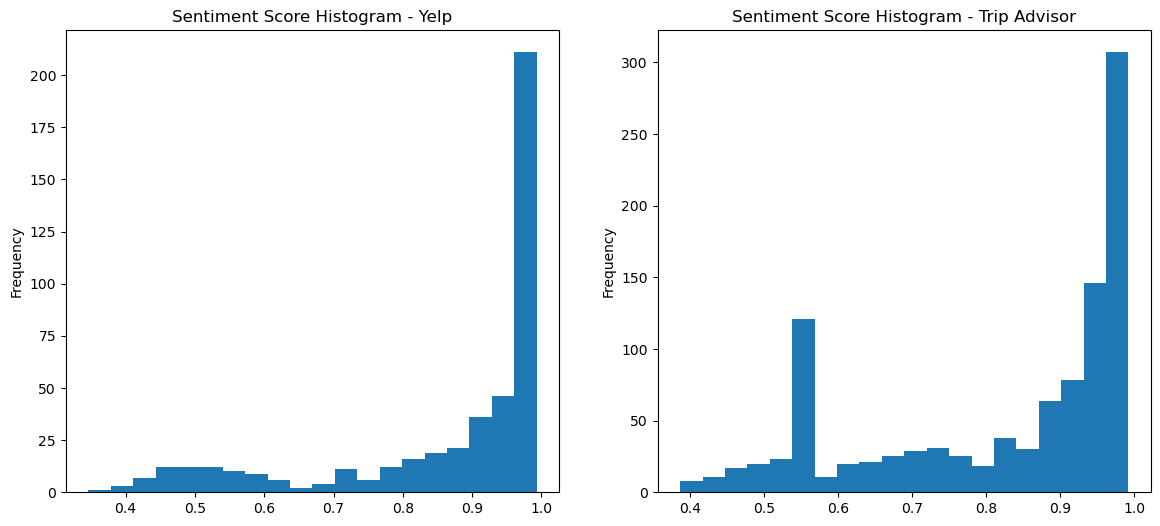

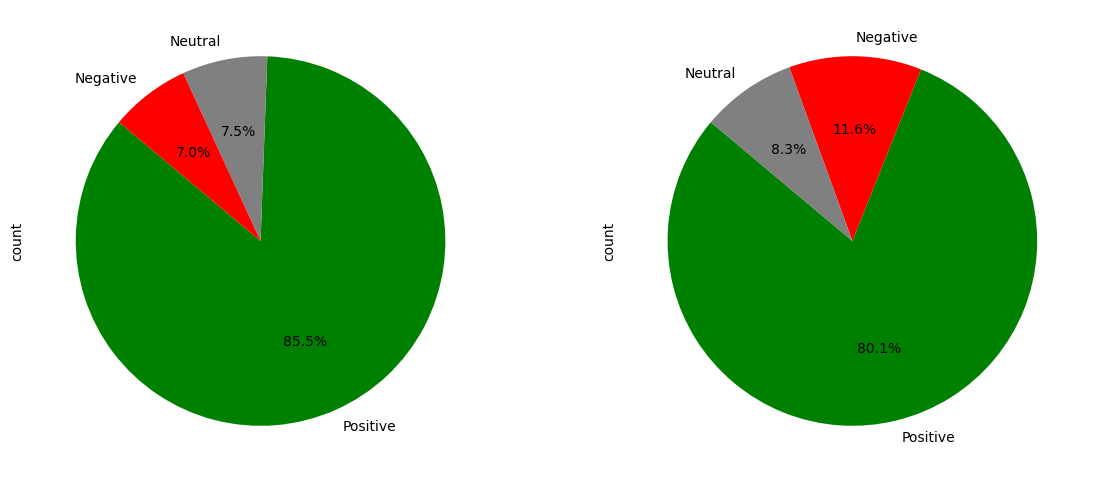

In [6]:
# Using a pipeline for sentiment-analysis with RoBERTa model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

# Function to analyze sentiment
def analyze_sentiment_hf(data, text_column):
    # Analyze sentiment
    data['sentiment_results'] = data[text_column].apply(lambda x: sentiment_analyzer(x[:512])[0] if isinstance(x, str) else None)
    # Map sentiment labels from the model's output to standard labels
    label_mapping = {
        'LABEL_0': 'Negative',
        'LABEL_1': 'Neutral',
        'LABEL_2': 'Positive'
    }
    data['label'] = data['sentiment_results'].apply(lambda x: label_mapping[x['label']] if x is not None else 'Neutral')
    data['score'] = data['sentiment_results'].apply(lambda x: x['score'] if x is not None else 0)

# Define color mapping for sentiment labels
color_mapping = {
    'Negative': 'red',
    'Neutral': 'gray',
    'Positive': 'green'
}

# Analyze sentiment for both datasets
analyze_sentiment_hf(df, 'comment')
analyze_sentiment_hf(df1, 'Content')

# Bar chart for sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x='label', data=df, palette=color_mapping, ax=axes[0])
axes[0].set_title('Sentiment Distribution - Yelp')
sns.countplot(x='label', data=df1, palette=color_mapping, ax=axes[1])
axes[1].set_title('Sentiment Distribution - Trip Advisor')
plt.show()

# Histogram for sentiment scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
df['score'].plot(kind='hist', bins=20, ax=axes[0], title='Sentiment Score Histogram - Yelp')
df1['score'].plot(kind='hist', bins=20, ax=axes[1], title='Sentiment Score Histogram - Trip Advisor')
plt.show()

# Pie chart for sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=[color_mapping[val] for val in df['label'].value_counts().index], ax=axes[0])
df1['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=[color_mapping[val] for val in df1['label'].value_counts().index], ax=axes[1])
plt.show()


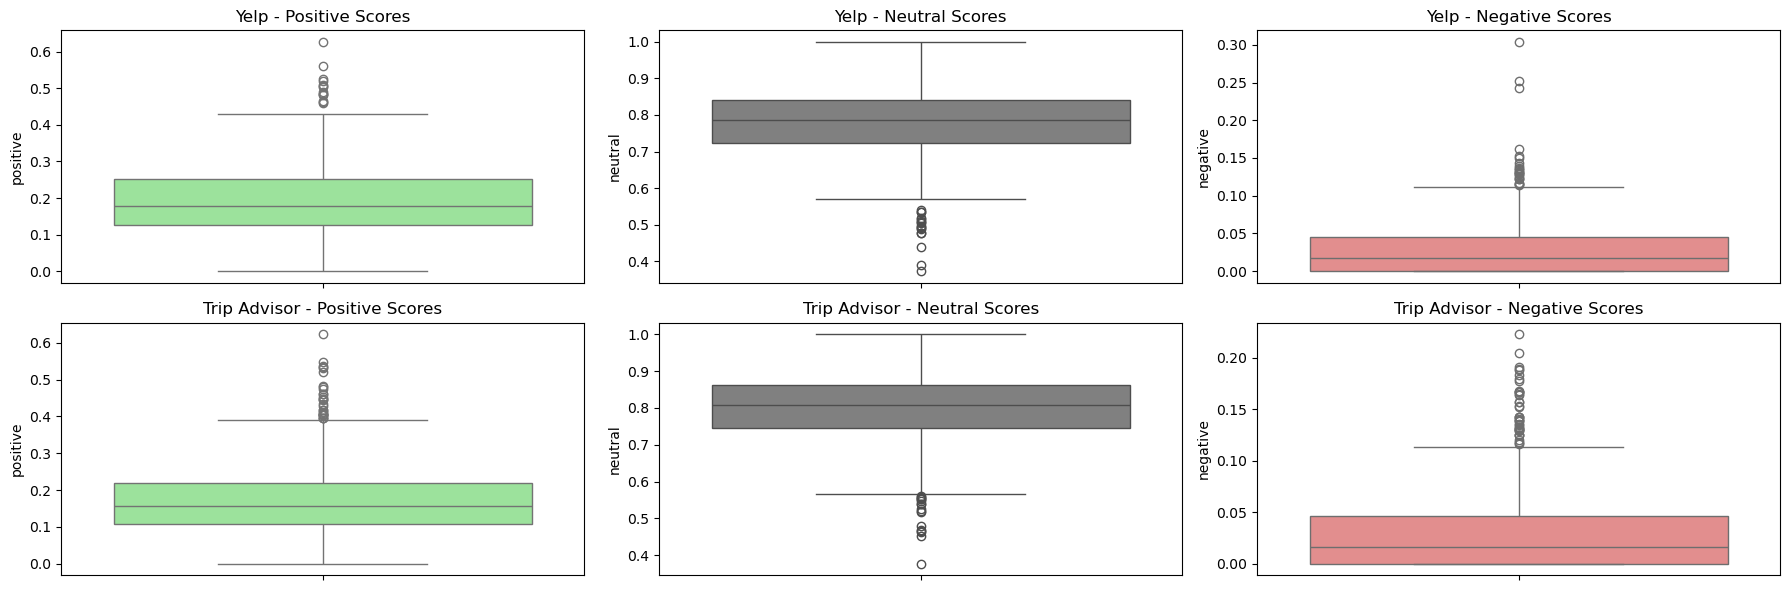

In [7]:
# Sentiment analysis using VADER
def analyze_sentiment_vader(data, text_column):
    sia = SentimentIntensityAnalyzer()
    scores = data[text_column].apply(lambda x: sia.polarity_scores(str(x)) if isinstance(x, str) else None)
    data['positive'] = scores.apply(lambda x: x['pos'] if x is not None else None)
    data['neutral'] = scores.apply(lambda x: x['neu'] if x is not None else None)
    data['negative'] = scores.apply(lambda x: x['neg'] if x is not None else None)

# Analyze sentiment for both DataFrames
analyze_sentiment_vader(df, 'comment')  
analyze_sentiment_vader(df1, 'Content')  

# Plot boxplot for individual sentiment scores
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Box plot for positive, neutral, and negative scores in df
sns.boxplot(y='positive', data=df, color='lightgreen', ax=axes[0, 0])
axes[0, 0].set_title('Yelp - Positive Scores')

sns.boxplot(y='neutral', data=df, color='gray', ax=axes[0, 1])
axes[0, 1].set_title('Yelp - Neutral Scores')

sns.boxplot(y='negative', data=df, color='lightcoral', ax=axes[0, 2])
axes[0, 2].set_title('Yelp - Negative Scores')

# Box plot for positive, neutral, and negative scores in df1
sns.boxplot(y='positive', data=df1, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Trip Advisor - Positive Scores')

sns.boxplot(y='neutral', data=df1, color='gray', ax=axes[1, 1])
axes[1, 1].set_title('Trip Advisor - Neutral Scores')

sns.boxplot(y='negative', data=df1, color='lightcoral', ax=axes[1, 2])
axes[1, 2].set_title('Trip Advisor - Negative Scores')

plt.tight_layout()
plt.show()


## Compare most frequently used words in Yelp and Trip advisor

### Comparing Nouns in both datasets

### Comparing Nouns using Spacy library

In [9]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Add custom stop words
custom_stop_words = {'more', 'many', 'much', 'nixon', 'library', 'museum'}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Function to count most frequent nouns
def count_most_frequent_nouns(text_series):
    all_nouns = []
    for doc in nlp.pipe(text_series.astype('str'), disable=["parser", "ner"]):
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN" and not token.is_stop and token.text.lower() not in custom_stop_words]
        all_nouns.extend(nouns)
    return Counter(all_nouns).most_common(30)

# Count most frequent nouns in 'comment' and 'Content'
most_frequent_nouns_yelp = count_most_frequent_nouns(df['comment'])
most_frequent_nouns_tripadvisor = count_most_frequent_nouns(df1['Content'])

# Function to print most frequent nouns
def print_most_frequent_nouns(most_frequent, dataset_name):
    print(f"Most Frequent Nouns in {dataset_name} Dataset:")
    for noun, count in most_frequent:
        print(f"{noun}: {count}")
    print("\n")

# Print the most frequent nouns for each dataset
print_most_frequent_nouns(most_frequent_nouns_yelp, "Yelp")
print_most_frequent_nouns(most_frequent_nouns_tripadvisor, "TripAdvisor")


Most Frequent Nouns in Yelp Dataset:
place: 264
time: 224
history: 199
wedding: 195
helicopter: 150
house: 131
home: 116
lot: 115
exhibits: 105
life: 103
venue: 100
day: 100
tour: 97
president: 94
visit: 94
people: 92
garden: 85
grounds: 84
hours: 75
things: 75
family: 75
staff: 74
room: 73
exhibit: 70
years: 67
experience: 63
way: 62
office: 60
area: 57
parking: 54


Most Frequent Nouns in TripAdvisor Dataset:
time: 395
history: 350
home: 308
helicopter: 281
life: 264
visit: 259
exhibits: 240
grounds: 239
place: 225
house: 192
hours: 179
tour: 159
presidency: 147
lot: 141
birthplace: 136
man: 126
president: 124
exhibit: 124
years: 120
family: 115
displays: 105
things: 104
libraries: 101
day: 99
information: 97
gardens: 97
trip: 93
site: 91
office: 90
area: 84




### Comparing adjectives using NLTK 

In [10]:
# Make sure to download the required NLTK resources
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')  # For part-of-speech tagging


# Define custom stop words
custom_stop_words = {'more', 'many', 'much'}

# Function to count most frequent adjectives
def count_most_frequent_adjectives(text_series):
    all_adjectives = []
    for text in text_series:
        tokens = word_tokenize(text)  # Tokenize the text
        tagged_tokens = pos_tag(tokens)  # Tag each token with its part-of-speech
        adjectives = [word.lower() for word, tag in tagged_tokens if tag.startswith('JJ') and word.lower() not in custom_stop_words]
        all_adjectives.extend(adjectives)
    return Counter(all_adjectives).most_common(30)

# Count most frequent adjectives in 'comment' and 'Content'
most_frequent_adjectives_yelp = count_most_frequent_adjectives(df['comment'])
most_frequent_adjectives_tripadvisor = count_most_frequent_adjectives(df1['Content'])

# Function to print most frequent adjectives
def print_most_frequent_adjectives(most_frequent, dataset_name):
    print(f"Most Frequent Adjectives in {dataset_name} Dataset:")
    for word, count in most_frequent:
        print(f"{word}: {count}")
    print("\n")

# Print the most frequent adjectives for each dataset
print_most_frequent_adjectives(most_frequent_adjectives_yelp, "Yelp")
print_most_frequent_adjectives(most_frequent_adjectives_tripadvisor, "TripAdvisor")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Most Frequent Adjectives in Yelp Dataset:
great: 174
presidential: 150
beautiful: 136
nice: 100
good: 86
other: 82
first: 79
free: 74
interesting: 70
little: 64
entire: 52
library: 49
sure: 49
cool: 48
political: 47
such: 45
few: 42
amazing: 42
large: 42
informative: 40
actual: 40
friendly: 38
special: 37
best: 37
able: 37
small: 35
original: 34
last: 31
most: 31
american: 31


Most Frequent Adjectives in TripAdvisor Dataset:
presidential: 293
great: 262
good: 211
interesting: 193
beautiful: 172
other: 113
nice: 110
first: 102
informative: 100
political: 96
original: 86
few: 84
excellent: 80
library: 72
small: 69
wonderful: 65
most: 65
early: 62
little: 61
free: 61
new: 60
better: 56
knowledgeable: 55
best: 49
last: 48
available: 48
sure: 47
open: 47
actual: 46
historical: 46




### Nouns using spaCy

In [11]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Add custom stop words
custom_stop_words = {'more', 'many', 'much', 'nixon', 'library'}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Function to count most frequent nouns
def count_most_frequent_nouns(text_series):
    noun_counts = Counter()
    for doc in nlp.pipe(text_series.astype('str'), disable=["parser", "ner"]):
        for token in doc:
            if token.is_alpha and not token.is_stop and token.pos_ == "NOUN":
                noun_counts[token.text.lower()] += 1
    return noun_counts.most_common(30)

# Count most frequent nouns in 'comment' and 'Content'
top_30_nouns_yelp = dict(count_most_frequent_nouns(df['comment']))
top_30_nouns_tripadvisor = dict(count_most_frequent_nouns(df1['Content']))

# Create a DataFrame for the comparison
nouns_table = pd.DataFrame(columns=['Yelp', 'TripAdvisor', 'Common', 'Unique_Yelp', 'Unique_TripAdvisor'])

# Fill in the counts for Yelp and TripAdvisor
for noun, count in top_30_nouns_yelp.items():
    nouns_table.loc[noun, 'Yelp'] = count

for noun, count in top_30_nouns_tripadvisor.items():
    nouns_table.loc[noun, 'TripAdvisor'] = count

# Mark common and unique nouns
nouns_table['Common'] = nouns_table.apply(lambda row: row['Yelp'] > 0 and row['TripAdvisor'] > 0, axis=1)
nouns_table['Unique_Yelp'] = nouns_table.apply(lambda row: row['Yelp'] > 0 and row['TripAdvisor'] == 0, axis=1)
nouns_table['Unique_TripAdvisor'] = nouns_table.apply(lambda row: row['Yelp'] == 0 and row['TripAdvisor'] > 0, axis=1)

# Fill missing values with 0
nouns_table.fillna(0, inplace=True)

# Display the DataFrame
nouns_table


Yelp  TripAdvisor  Common  Unique_Yelp  Unique_TripAdvisor
museum        309          522    True        False               False
place         264          225    True        False               False
time          224          395    True        False               False
history       199          350    True        False               False
wedding       195            0   False        False               False
helicopter    150          281    True        False               False
house         131          192    True        False               False
home          116          308    True        False               False
lot           115          141    True        False               False
exhibits      105          240    True        False               False
life          103          264    True        False               False
venue         100            0   False        False               False
day           100           99    True        False               False
tour           97          159    True        False               False
president      94          124    True        False               False
visit          94          259    True        False               False
people         92            0   False        False               False
garden         85            0   False        False               False
grounds        84          239    True        False               False
hours          75          179    True        False               False
things         75          104    True        False               False
family         75          115    True        False               False
staff          74            0   False        False               False
room           73            0   False        False               False
exhibit        70          124    True        False               False
years          67          120    True        False               False
experience     63            0   False        False               False
way            62            0   False        False               False
office         60           90    True        False               False
area           57            0   False        False               False
presidency      0          147   False        False               False
birthplace      0          136   False        False               False
man             0          126   False        False               False
displays        0          105   False        False               False
libraries       0          101   False        False               False
information     0           97   False        False               False
gardens         0           97   False        False               False
trip            0           93   False        False               False
site            0           91   False        False               False

### Adjectives using spaCy

In [12]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Add custom stop words
custom_stop_words = {'more', 'many', 'much', 'nixon', 'library'}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Function to count most frequent adjectives
def count_most_frequent_adjectives(text_series):
    adjective_counts = Counter()
    for doc in nlp.pipe(text_series.astype('str'), disable=["parser", "ner"]):
        for token in doc:
            if token.is_alpha and not token.is_stop and token.pos_ == "ADJ":
                adjective_counts[token.text.lower()] += 1
    return adjective_counts.most_common(30)

# Count most frequent adjectives in 'comment' and 'Content'
top_30_adjectives_yelp = dict(count_most_frequent_adjectives(df['comment']))
top_30_adjectives_tripadvisor = dict(count_most_frequent_adjectives(df1['Content']))

# Create a DataFrame for the comparison
adjectives_table = pd.DataFrame(columns=['Yelp', 'TripAdvisor'])

# Fill in the counts for Yelp and TripAdvisor
for adj, count in top_30_adjectives_yelp.items():
    adjectives_table.loc[adj, 'Yelp'] = count

for adj, count in top_30_adjectives_tripadvisor.items():
    adjectives_table.loc[adj, 'TripAdvisor'] = count

# Fill missing values with 0
adjectives_table.fillna(0, inplace=True)

# Identify unique adjectives for each dataset
adjectives_table['Unique_Yelp'] = adjectives_table.apply(lambda row: row['Yelp'] > 0 and row['TripAdvisor'] == 0, axis=1)
adjectives_table['Unique_TripAdvisor'] = adjectives_table.apply(lambda row: row['Yelp'] == 0 and row['TripAdvisor'] > 0, axis=1)

# Sort by frequency in Yelp, then TripAdvisor
adjectives_table.sort_values(by=['Yelp', 'TripAdvisor'], ascending=False, inplace=True)

# Display the DataFrame
adjectives_table.head(30)  # Display the top 30 rows


Yelp  TripAdvisor  Unique_Yelp  Unique_TripAdvisor
great          192          282        False               False
beautiful      150          191        False               False
presidential   147          304        False               False
nice           112          123        False               False
interesting     92          268        False               False
good            84          197        False               False
free            76           66        False               False
little          68           62        False               False
cool            62            0         True               False
worth           58          185        False               False
amazing         57           51        False               False
sure            52           52        False               False
entire          52            0         True               False
political       48           99        False               False
friendly        43            0         True               False
informative     42          101        False               False
large           42            0         True               False
best            41           49        False               False
actual          40            0         True               False
small           39           71        False               False
able            38            0         True               False
special         36            0         True               False
original        33           87        False               False
better          30           63        False               False
open            30           50        False               False
big             30            0         True               False
gorgeous        30            0         True               False
american        28            0         True               False
favorite        27            0         True               False
easy            26           48        False               False

## Word Clouds for Yelp and TripAdvisor 

### Yelp word cloud - Noun and Adjective 

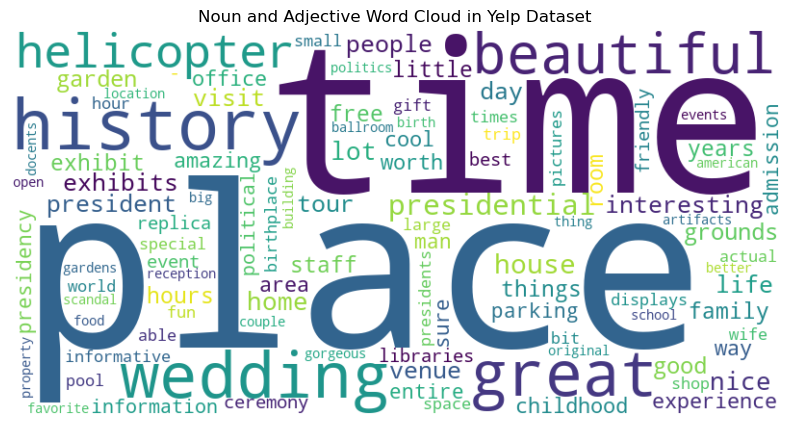

In [13]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Add custom stop words
custom_stop_words = {"nixon", "museum","library"}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Initialize empty word frequency counter for nouns and adjectives
noun_adjective_counts = Counter()

# Process the text data to extract nouns and adjectives
for text in df['comment']:
    doc = nlp(text)
    noun_adjective_tokens = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'ADJ'] and not token.is_stop]
    noun_adjective_counts.update(noun_adjective_tokens)

# Create a word cloud for the combined noun and adjective counts
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(noun_adjective_counts, "Noun and Adjective Word Cloud in Yelp Dataset")


### Yelp word Cloud for Nouns - Positive, Neutral and Negative sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

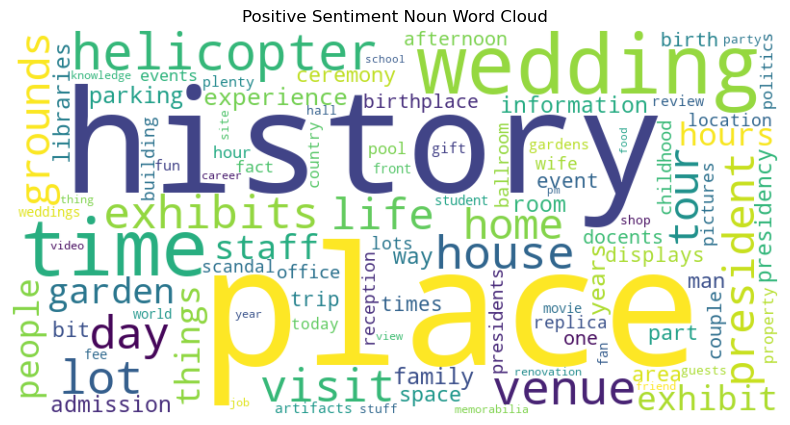

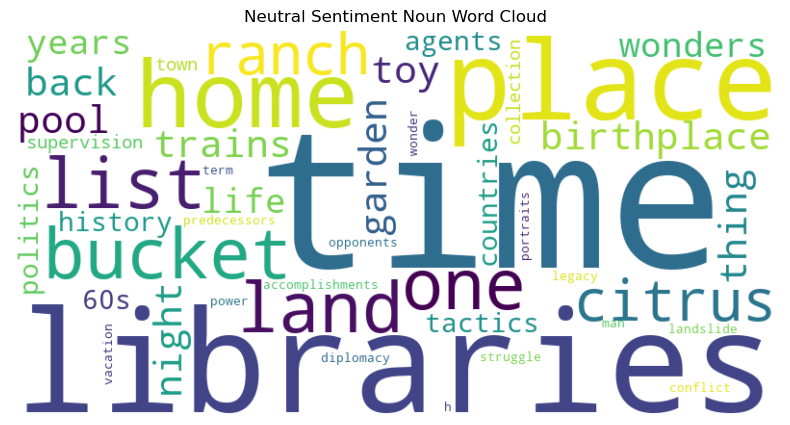

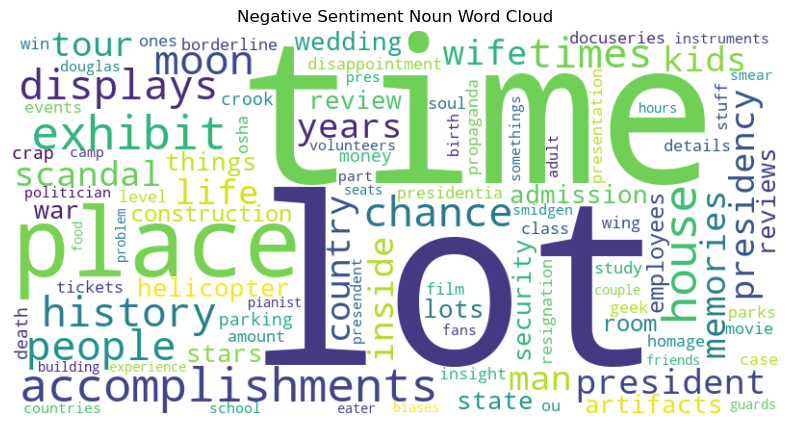

In [14]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Initialize NLTK VADER
sia = SentimentIntensityAnalyzer()

# Initialize Hugging Face Roberta model and tokenizer
model_name = 'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize a list of words to remove
words_to_remove = ["nixon", "museum", "library"]

# Convert the words to lowercase for case-insensitive comparison
words_to_remove_lower = [word.lower() for word in words_to_remove]

# Initialize spaCy with a language model (English)
nlp = spacy.load("en_core_web_sm")

# Initialize empty word frequency counters for each sentiment category
positive_word_counts = Counter()
neutral_word_counts = Counter()
negative_word_counts = Counter()

for i, row in df.iterrows():
    text = row['comment']
    vader_result = sia.polarity_scores(text)

    # Truncate or split the text to fit within the model's maximum sequence length
    max_seq_length = model.config.max_position_embeddings
    if len(text) > max_seq_length:
        text = text[:max_seq_length]  # Truncate the text

    roberta_result = model(**tokenizer(text, return_tensors='pt', padding=True, truncation=True))

    # Determine sentiment category (positive, neutral, or negative)
    if vader_result['compound'] >= 0.05:
        sentiment_category = 'positive'
    elif vader_result['compound'] <= -0.05:
        sentiment_category = 'negative'
    else:
        sentiment_category = 'neutral'

    # Process the text with spaCy to extract nouns and update the word frequency counts
    doc = nlp(text)
    nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and token.text.lower() not in words_to_remove_lower]
    word_counts = Counter(nouns)

    if sentiment_category == 'positive':
        positive_word_counts.update(word_counts)
    elif sentiment_category == 'negative':
        negative_word_counts.update(word_counts)
    else:
        neutral_word_counts.update(word_counts)

# Create word clouds for each sentiment category
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(positive_word_counts, "Positive Sentiment Noun Word Cloud")
generate_word_cloud(neutral_word_counts, "Neutral Sentiment Noun Word Cloud")
generate_word_cloud(negative_word_counts, "Negative Sentiment Noun Word Cloud")


###  Yelp word Cloud for Adjectives - Positive, Neutral and Negative sentiment

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


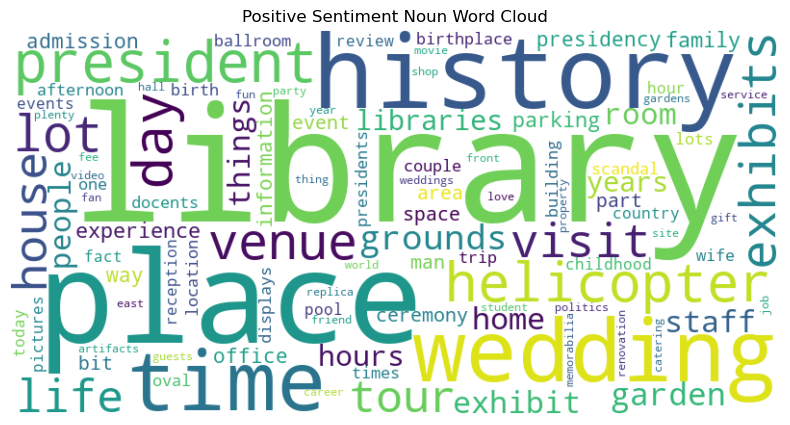

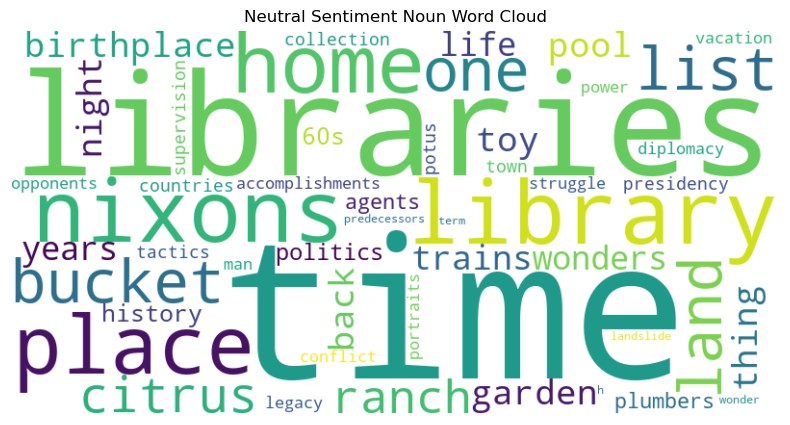

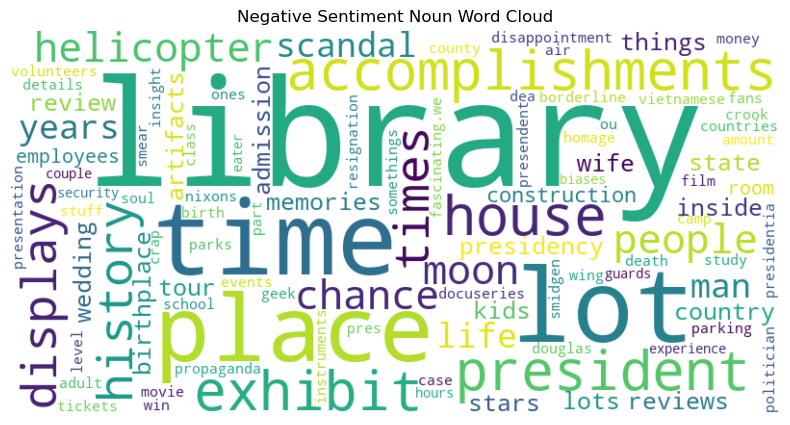

In [15]:
# Initialize NLTK VADER
sia = SentimentIntensityAnalyzer()

# Initialize Hugging Face Roberta model and tokenizer
model_name = 'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize spaCy with a language model (English)
nlp = spacy.load("en_core_web_sm")

# Initialize a list of words to remove, all in lowercase to ensure case-insensitive matching
words_to_remove = ["nixon", "museum"]

# Convert words_to_remove to lowercase for case-insensitive comparison
words_to_remove = [word.lower() for word in words_to_remove]

# Initialize empty word frequency counters for each sentiment category
positive_word_counts = Counter()
neutral_word_counts = Counter()
negative_word_counts = Counter()

for i, row in df.iterrows():
    text = row['comment'].lower()  # Convert text to lowercase to ensure case-insensitive processing
    vader_result = sia.polarity_scores(text)

    # Truncate or split the text to fit within the model's maximum sequence length
    max_seq_length = model.config.max_position_embeddings
    if len(text) > max_seq_length:
        text = text[:max_seq_length]  # Truncate the text

    roberta_result = model(**tokenizer(text, return_tensors='pt', padding=True, truncation=True))

    # Determine sentiment category (positive, neutral, or negative)
    if vader_result['compound'] >= 0.05:
        sentiment_category = 'positive'
    elif vader_result['compound'] <= -0.05:
        sentiment_category = 'negative'
    else:
        sentiment_category = 'neutral'

    # Process the text with spaCy to extract nouns, convert to lowercase, and update the word frequency counts, filtering out removed words
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN' and token.text not in words_to_remove]  # Corrected to extract nouns and filter words
    word_counts = Counter(nouns)

    if sentiment_category == 'positive':
        positive_word_counts.update(word_counts)
    elif sentiment_category == 'negative':
        negative_word_counts.update(word_counts)
    else:
        neutral_word_counts.update(word_counts)

# Create word clouds for each sentiment category
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(positive_word_counts, "Positive Sentiment Noun Word Cloud")
generate_word_cloud(neutral_word_counts, "Neutral Sentiment Noun Word Cloud")
generate_word_cloud(negative_word_counts, "Negative Sentiment Noun Word Cloud")

### Trip Advisor Noun and Adjective

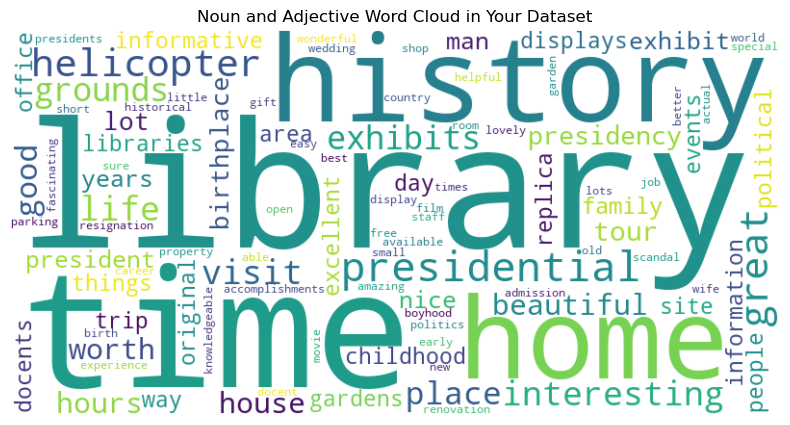

In [16]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Add custom stop words
custom_stop_words = {"nixon", "museum"}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Initialize empty word frequency counter for nouns and adjectives
noun_adjective_counts = Counter()

# Process the text data to extract nouns and adjectives
for text in df1['Content']:
    doc = nlp(text)
    noun_adjective_tokens = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'ADJ'] and not token.is_stop]
    noun_adjective_counts.update(noun_adjective_tokens)

# Create a word cloud for the combined noun and adjective counts
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(noun_adjective_counts, "Noun and Adjective Word Cloud in Your Dataset")


### Trip Advisor Noun word cloud with positive, neutral and negative sentiment

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


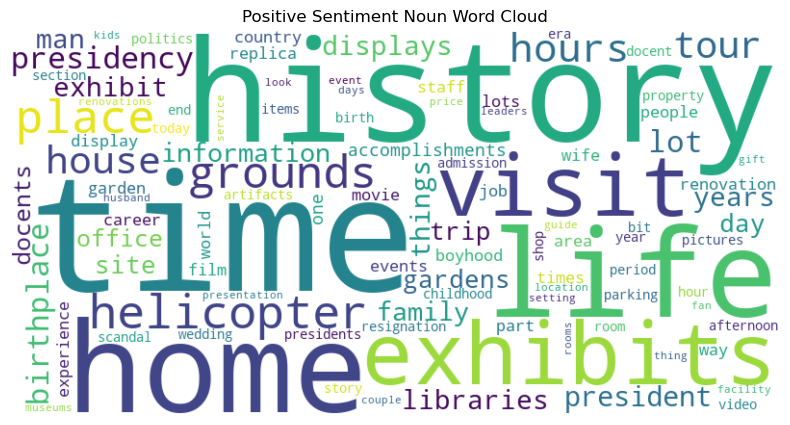

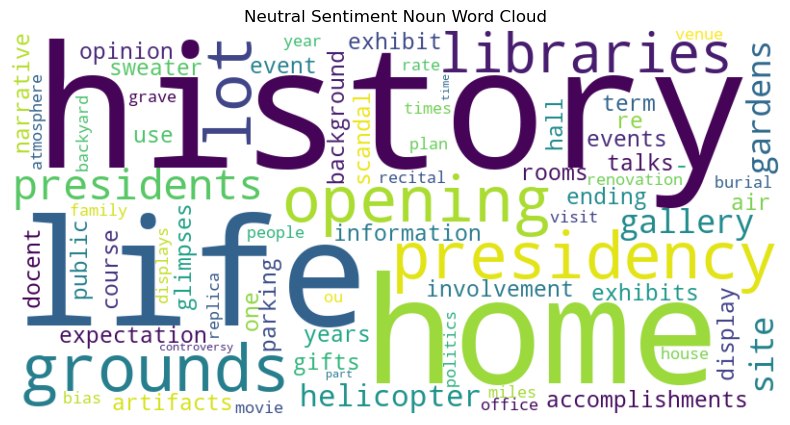

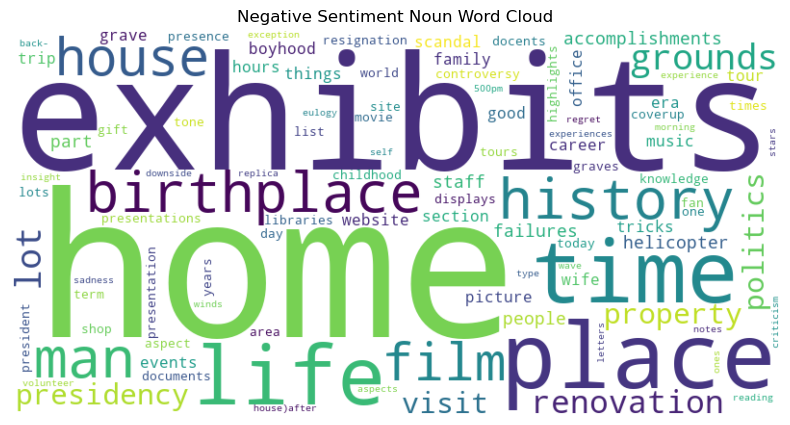

In [17]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy

# Initialize NLTK VADER
sia = SentimentIntensityAnalyzer()

# Initialize Hugging Face Roberta model and tokenizer
model_name = 'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize a list of words to remove in any case
words_to_remove = ["nixon", "museum", "library"]

# Convert the words to lowercase for case-insensitive comparison
words_to_remove_lower = [word.lower() for word in words_to_remove]

# Initialize spaCy with a language model (English)
nlp = spacy.load("en_core_web_sm")

# Initialize empty word frequency counters for each sentiment category
positive_word_counts = Counter()
neutral_word_counts = Counter()
negative_word_counts = Counter()

for i, row in df1.iterrows():
    text = row['Content']
    vader_result = sia.polarity_scores(text)

    # Truncate or split the text to fit within the model's maximum sequence length
    max_seq_length = model.config.max_position_embeddings
    if len(text) > max_seq_length:
        text = text[:max_seq_length]  # Truncate the text

    roberta_result = model(**tokenizer(text, return_tensors='pt', padding=True, truncation=True))

    # Determine sentiment category (positive, neutral, or negative)
    if vader_result['compound'] >= 0.05:
        sentiment_category = 'positive'
    elif vader_result['compound'] <= -0.05:
        sentiment_category = 'negative'
    else:
        sentiment_category = 'neutral'

    # Process the text with spaCy to extract nouns and update the word frequency counts
    doc = nlp(text)
    nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and token.text.lower() not in words_to_remove_lower]
    word_counts = Counter(nouns)

    if sentiment_category == 'positive':
        positive_word_counts.update(word_counts)
    elif sentiment_category == 'negative':
        negative_word_counts.update(word_counts)
    else:
        neutral_word_counts.update(word_counts)

# Create word clouds for each sentiment category
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(positive_word_counts, "Positive Sentiment Noun Word Cloud")
generate_word_cloud(neutral_word_counts, "Neutral Sentiment Noun Word Cloud")
generate_word_cloud(negative_word_counts, "Negative Sentiment Noun Word Cloud")


### Trip Advisor Adjective word cloud with positive, neutral and negative sentiment

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


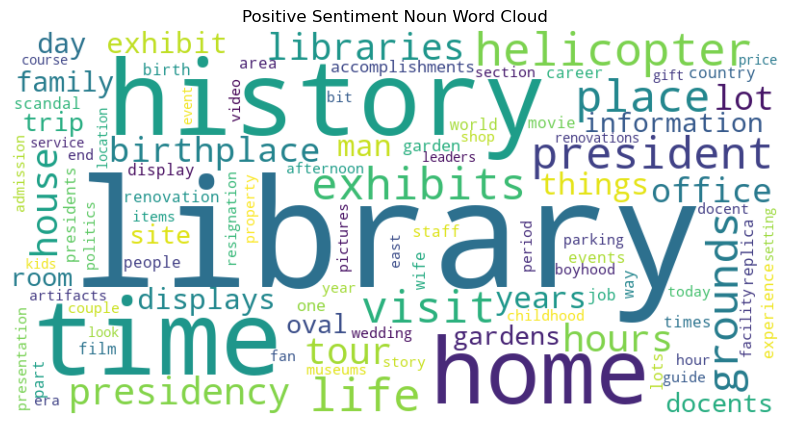

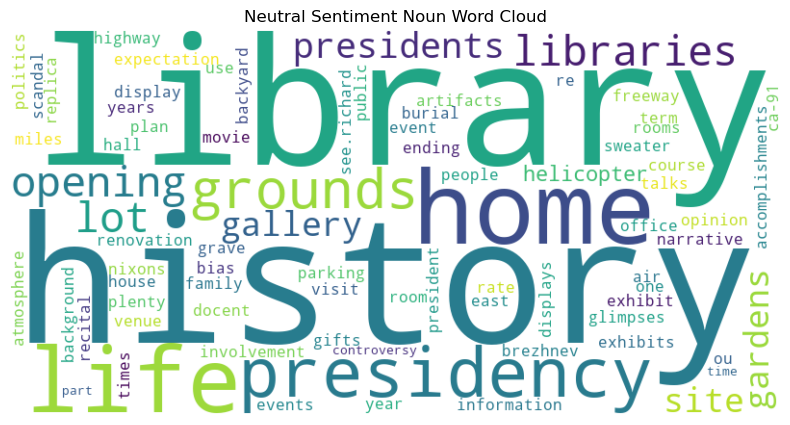

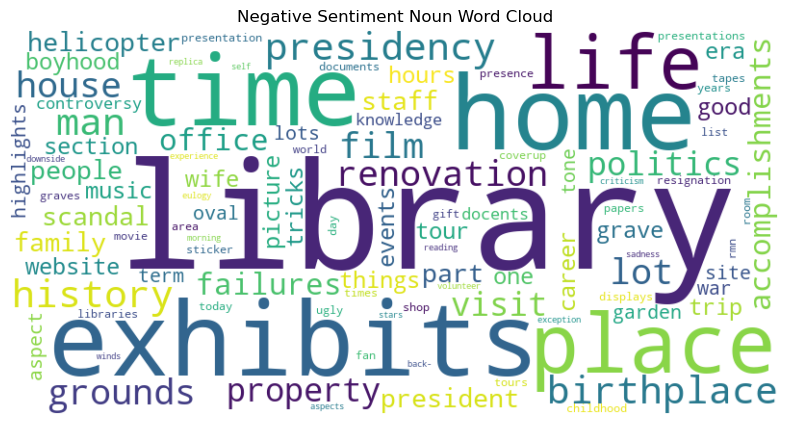

In [18]:
# Initialize NLTK VADER
sia = SentimentIntensityAnalyzer()

# Initialize Hugging Face Roberta model and tokenizer
model_name = 'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize spaCy with a language model (English)
nlp = spacy.load("en_core_web_sm")

# Initialize a list of words to remove, all in lowercase to ensure case-insensitive matching
words_to_remove = ["nixon", "museum", "more", "most"]

# Initialize empty word frequency counters for each sentiment category
positive_word_counts = Counter()
neutral_word_counts = Counter()
negative_word_counts = Counter()

for i, row in df1.iterrows():
    text = row['Content'].lower()  # Convert text to lowercase to ensure case-insensitive processing
    vader_result = sia.polarity_scores(text)

    # Truncate or split the text to fit within the model's maximum sequence length
    max_seq_length = model.config.max_position_embeddings
    if len(text) > max_seq_length:
        text = text[:max_seq_length]  # Truncate the text

    roberta_result = model(**tokenizer(text, return_tensors='pt', padding=True, truncation=True))

    # Determine sentiment category (positive, neutral, or negative)
    if vader_result['compound'] >= 0.05:
        sentiment_category = 'positive'
    elif vader_result['compound'] <= -0.05:
        sentiment_category = 'negative'
    else:
        sentiment_category = 'neutral'

    # Process the text with spaCy to extract nouns and update the word frequency counts, filtering out removed words
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN' and token.text not in words_to_remove]  # Corrected to extract nouns and filter words
    word_counts = Counter(nouns)

    if sentiment_category == 'positive':
        positive_word_counts.update(word_counts)
    elif sentiment_category == 'negative':
        negative_word_counts.update(word_counts)
    else:
        neutral_word_counts.update(word_counts)

# Create word clouds for each sentiment category
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_word_cloud(positive_word_counts, "Positive Sentiment Noun Word Cloud")
generate_word_cloud(neutral_word_counts, "Neutral Sentiment Noun Word Cloud")
generate_word_cloud(negative_word_counts, "Negative Sentiment Noun Word Cloud")

#### 1. Text Vectorization
First, we convert the textual content of the reviews into numerical form using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings (e.g., Word2Vec, GloVe). TF-IDF highlights the importance of words within documents in a corpus, while embeddings capture semantic similarities between words.

#### 2. Dimensionality Reduction
Text data, once vectorized, can be extremely high-dimensional. Dimensionality reduction techniques like PCA (Principal Component Analysis) or t-SNE can reduce the number of features while preserving the essential relationships in the data, making the clustering process more efficient and interpretable.

#### 3. Clustering
With the data in a suitable numerical format and dimensionality reduced, we can apply clustering algorithms. Beyond K-Means, algorithms like DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or HDBSCAN (Hierarchical DBSCAN) can be used. These algorithms do not require specifying the number of clusters beforehand and are adept at finding clusters of varying shapes and densities

### Clustering in Trip Advisor Data 

### Methodology:

#### Preprocessing Text Data:

Load the dataset and focus on the Content column.
Clean the text data by removing punctuation, numbers, and special characters.
Lowercase all words to ensure consistency.
Tokenize the text data.
Remove stop words to eliminate common but uninformative words.
Apply stemming or lemmatization to reduce words to their base or root form.

#### Feature Extraction:

Convert the cleaned, preprocessed text into numerical features. This can be done using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings.

#### Clustering:

Use a clustering algorithm to group the reviews into clusters based on their textual content. K-means is a popular choice for its simplicity, but other algorithms like hierarchical clustering or DBSCAN might also be appropriate depending on the data distribution.


#### Choosing the Number of Clusters:

If using K-means, determine the optimal number of clusters using methods like the Elbow method or the Silhouette score.

### TF-IDF model with Dimensionality reduction using PCA and Clustering using DBSCAN

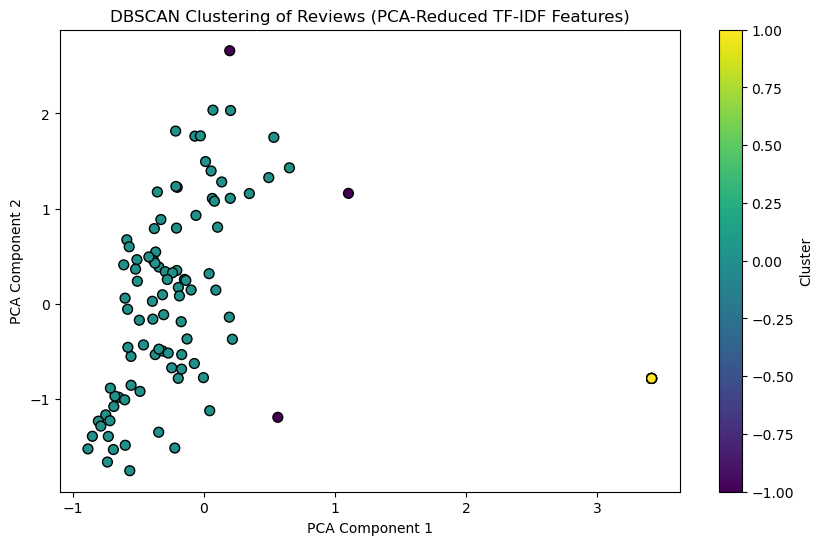

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Sample a subset of the data for demonstration purposes
data_subset = df1['Content'].sample(n=100, random_state=42)

# 1. Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(data_subset).toarray()

# 2. Dimensionality Reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_tfidf)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# 3. Clustering
dbscan = DBSCAN(eps=0.5, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Reviews (PCA-Reduced TF-IDF Features)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

The plot above visualizes the results of clustering a subset of the reviews using DBSCAN after reducing the dimensionality of TF-IDF features with PCA. Each point represents a review, and the colors indicate different clusters identified by DBSCAN. Points that may appear as outliers (not belonging to any cluster) are a characteristic feature of DBSCAN, which can identify dense regions of data points while treating sparse points as noise.

This visualization shows how reviews can be grouped based on the similarity of their content after being transformed into a numerical representation and reduced to two principal components for easy visualization. The clustering could reveal patterns or groups of reviews with similar themes or sentiments not immediately apparent through sentiment scores alone.

In [ ]:
### TF-IDF model with Agglomerative Hierarchical Clustering 

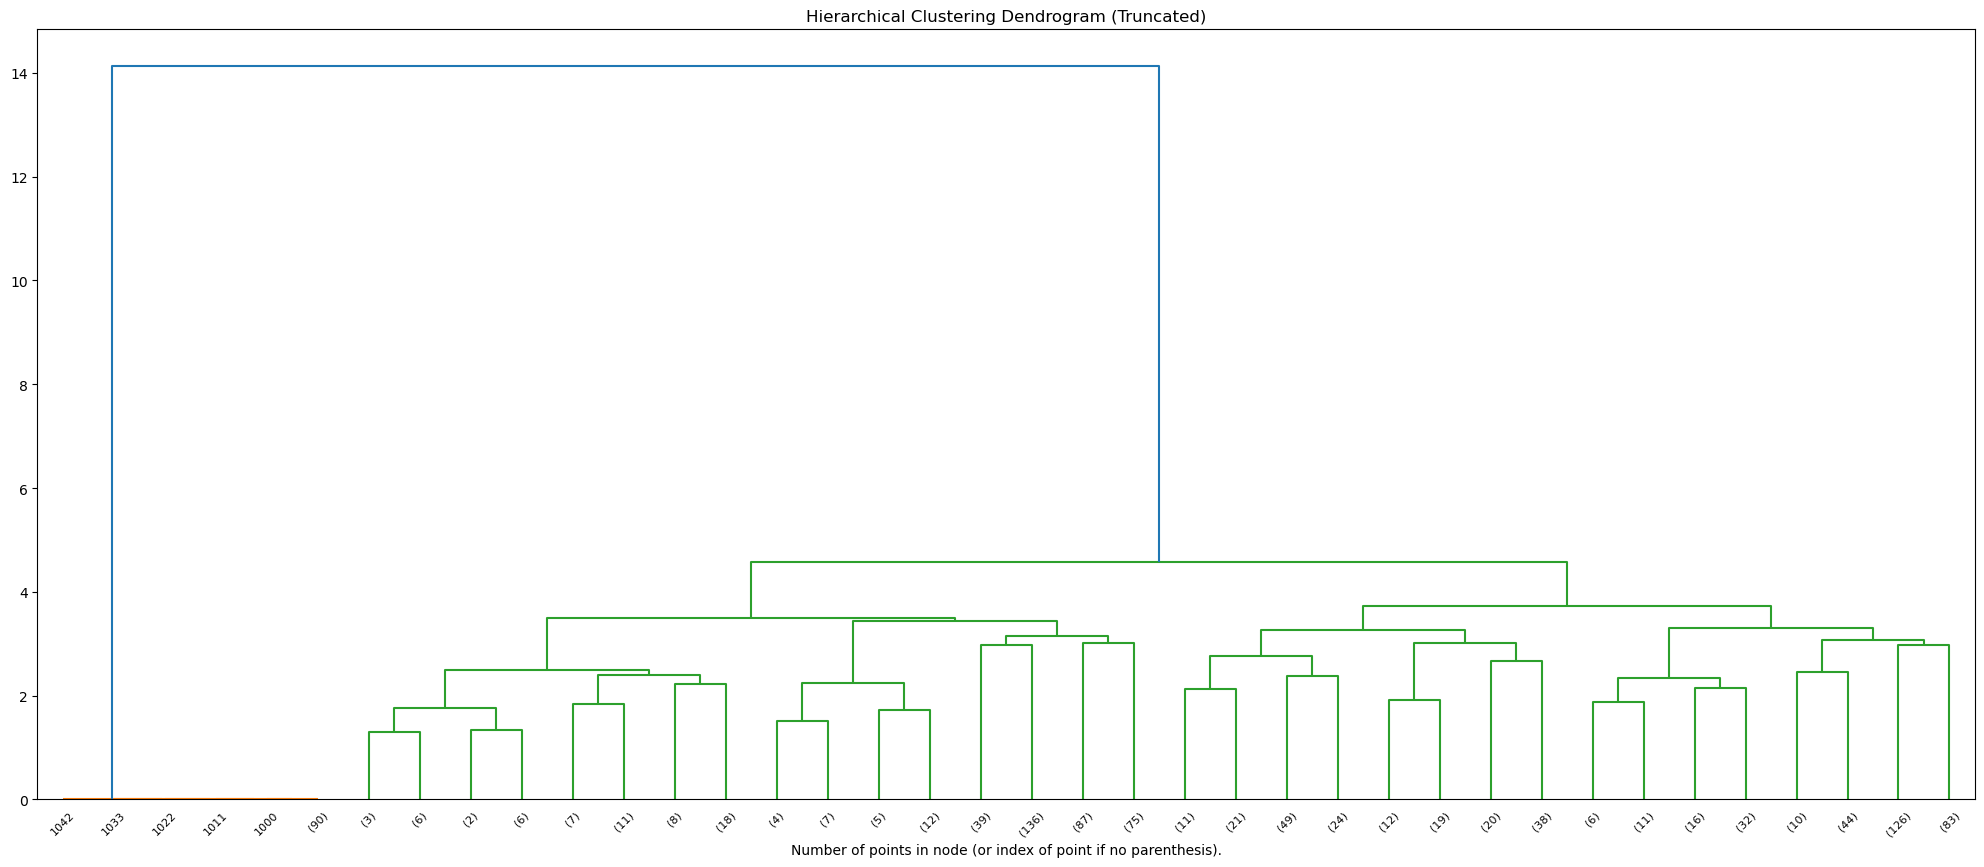

In [42]:
# Preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text

# Apply preprocessing to the Content column
df['processed_content'] = df['Content'].apply(preprocess_text)

# Feature Extraction with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_content']).toarray()

# Clustering with Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
clusters = agg_clustering.fit_predict(X_tfidf)

def plot_dendrogram(model, truncate_mode='level', p=5, **kwargs):
    # Creates the linkage matrix and then plots the dendrogram
    from scipy.cluster.hierarchy import dendrogram, linkage
    
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the dendrogram
    dendrogram(linkage_matrix, truncate_mode=truncate_mode, p=p, **kwargs)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plot_dendrogram(agg_clustering, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



#### Methodology

##### <strong> Preprocessing Text Data: </strong> The initial steps involve cleaning the text data from the "Content" column by removing punctuation, numbers, and making all words lowercase to ensure consistency. Further preprocessing steps include tokenizing the text data, removing stop words to eliminate common but uninformative words, and applying stemming or lemmatization to bring words to their base or root form.

##### <strong> Feature Extraction:</strong> The cleaned, preprocessed text is then converted into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency), which reflects the importance of words to the documents in which they appear.

##### <strong> Clustering: </strong> With the text data converted into a numerical representation, hierarchical clustering is applied to group the reviews into clusters based on their textual content. This clustering technique does not require specifying the number of clusters a priori and allows for the examination of cluster formations at different levels of granularity.

##### p value decides how granular we want ti go in the analysisrity.

### TF-IDF model clustering using K-means - identified ideal clusters using silhouette method and elbow method

### Using Silhouette method 

##### Silhouette Score
<strong>Definition:</strong> The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

<strong>Interpretation:</strong> If the silhouette score is close to 1, it suggests that the clusters are well apart from each other and clearly defined. A score around 0 indicates overlapping clusters, and a score below 0 suggests that samples might have been assigned to the wrong cluster.

<strong>In Our  Analysis:</strong> The silhouette score was used to find the optimal number of clusters by comparing scores for different values of K. A higher silhouette score for a particular K suggests that it is a good number of clusters for your dataset, meaning that, on average, each review is more similar to other reviews in its cluster than to reviews in other clusters.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


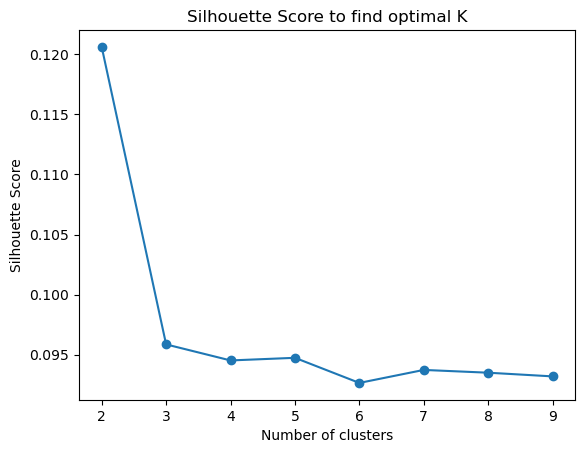

In [50]:
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import download

download('punkt')
download('stopwords')
download('wordnet')

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df1['processed_content']).toarray()

# Clustering
def optimal_k_search(data):
    scores = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    plt.plot(range(2, 10), scores, marker='o')
    plt.title('Silhouette Score to find optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

optimal_k_search(X)

                                             Content  Cluster
0  Visited here during US trip 2022. A pleasant p...        1
1  The wonderful legacy of Nixon was so wonderful...        1
2  Excellent presentation of the Nixon years. Des...        1
3  My girls are 16 & 14. It was great to see how ...        1
4  This is our second presidential library that w...        1
Cluster 0: found, president, interesting, house, display, family, presidency, garden, renovation, oval
Cluster 1: nixon, library, museum, president, well, visit, time, presidential, see, history


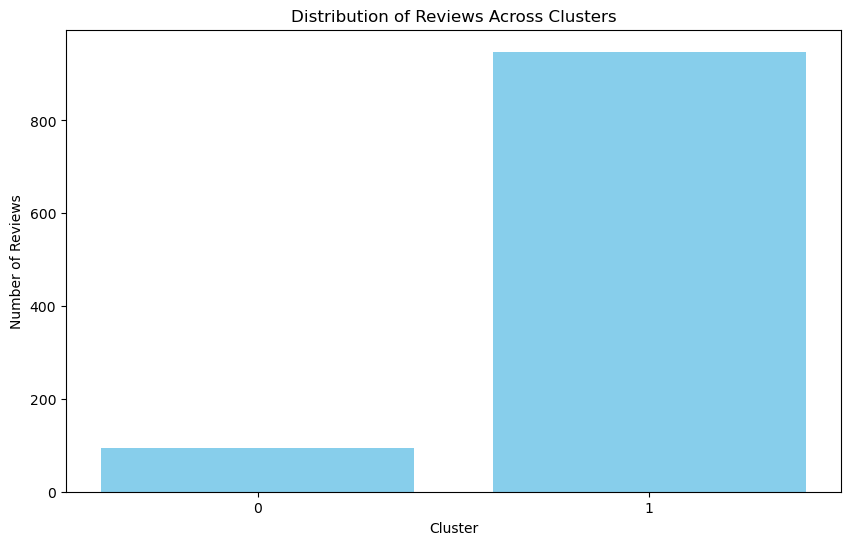

In [21]:
# Adjust according to the plot results (highest here is at 2)
kmeans = KMeans(n_clusters=2, random_state=42)
df1['Cluster'] = kmeans.fit_predict(X)

# Print the first few rows to inspect the clusters
print(df1[['Content', 'Cluster']].head())

# Function to print top terms per cluster
def print_top_terms_per_cluster(feature_names, n_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(2):
        print(f"Cluster {i}: ", end='')
        terms = [feature_names[ind] for ind in order_centroids[i, :n_terms]]
        print(', '.join(terms))

feature_names = tfidf_vectorizer.get_feature_names_out()
print_top_terms_per_cluster(feature_names)

# Plotting the cluster distribution
def plot_clusters_distribution():
    cluster_counts = df1['Cluster'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Reviews')
    plt.title('Distribution of Reviews Across Clusters')
    plt.xticks(cluster_counts.index)
    plt.show()

plot_clusters_distribution()

##### Using Elbow Method

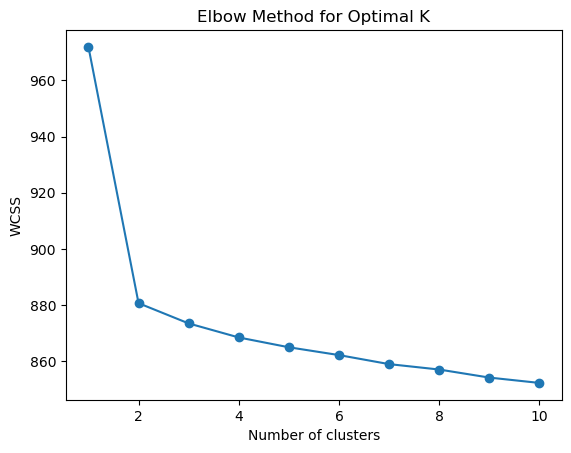

                                             Content  Cluster
0  Visited here during US trip 2022. A pleasant p...        1
1  The wonderful legacy of Nixon was so wonderful...        1
2  Excellent presentation of the Nixon years. Des...        1
3  My girls are 16 & 14. It was great to see how ...        1
4  This is our second presidential library that w...        1
Cluster 0: found, president, exhibit, house, tour, presidency, beautiful, family, time, would
Cluster 1: nixon, library, museum, president, well, visit, time, presidential, see, history


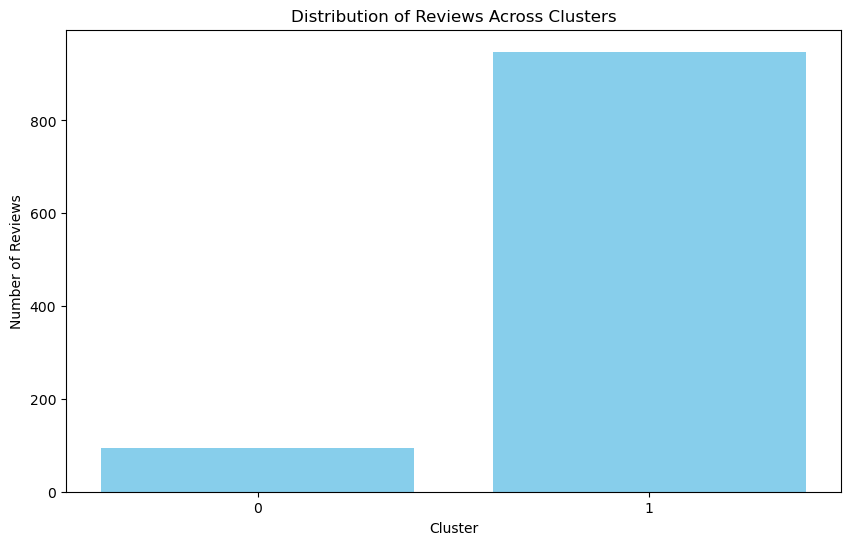

In [22]:
# Clustering using Elbow Method
def optimal_k_search(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

optimal_k_search(X)

optimal_k = 2  # Replace no. with the actual optimal number of clusters found from the Elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df1['Cluster'] = kmeans.fit_predict(X)

# Print the first few rows to inspect the clusters
print(df1[['Content', 'Cluster']].head())

# Function to print top terms per cluster
def print_top_terms_per_cluster(feature_names, n_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(optimal_k):
        print(f"Cluster {i}: ", end='')
        terms = [feature_names[ind] for ind in order_centroids[i, :n_terms]]
        print(', '.join(terms))

feature_names = tfidf_vectorizer.get_feature_names_out()
print_top_terms_per_cluster(feature_names)

# Plotting the cluster distribution
def plot_clusters_distribution():
    cluster_counts = df1['Cluster'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Reviews')
    plt.title('Distribution of Reviews Across Clusters')
    plt.xticks(cluster_counts.index)
    plt.show()

plot_clusters_distribution()

### Observation -> by using the silhouttee method and elbow method we found out that 2 clusters represent the best cluster fit for this dataset


### Clustering using Word2Vec, GloVe

#### Methodology:
<strong> Data Preparation:</strong> Load the dataset and extract the Content column, which contains the user reviews.

<strong>Text Preprocessing:</strong> Clean the text data by removing punctuation, numbers, and possibly stopwords. Convert text to lowercase to standardize it.

<strong>Word Embeddings:</strong> Convert the preprocessed text data into numerical form using word embeddings. We'll use a pre-trained model like GloVe or Word2Vec for this purpose. This step transforms the text into vectors that capture semantic meaning.

<strong>Clustering:</strong> Apply a clustering algorithm, such as K-means, on the word embeddings to cluster the reviews based on their semantic similarity. Determine the optimal number of clusters using methods like the elbow method or silhouette analysis.

<strong>Visualization:</strong> Use dimensionality reduction techniques (e.g., PCA, t-SNE) to visualize the clusters in a 2D or 3D space.

<strong>Interpretation:</strong> Analyze the clusters to understand the different sentiments or themes present in the reviews.


In [ ]:
from gensim.models import KeyedVectors

# Load pre-trained Word2Vec model
word2vec_path = 'path_to_word2vec.bin' 
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Load pre-trained GloVe model
glove_path = 'path_to_glove.txt'  
glove = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)


In [ ]:
# Function to transform reviews into vectors (averaging word vectors)
def review_to_vector(review, model):
    vec = np.zeros(model.vector_size)
    count = 0
    for word in review.split():
        if word in model.key_to_index:
            vec += model[word]
            count += 1
    return vec / count if count > 0 else vec

# Convert reviews to vectors (choose the model: word2vec or glove)
model = word2vec  # or glove
review_vectors = np.array([review_to_vector(review, model) for review in df['processed_content']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(review_vectors)  # Choose an appropriate number of clusters
df['cluster'] = kmeans.labels_

In [ ]:
# Convert reviews to vectors (choose the model: word2vec or glove)
model = word2vec  # 
review_vectors = np.array([review_to_vector(review, model) for review in df['processed_content']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(review_vectors)  # Choose an appropriate number of clusters
df['cluster'] = kmeans.labels_

In [ ]:
# Convert reviews to vectors (choose the model: word2vec or glove)
model = glove  #model
review_vectors1 = np.array([review_to_vector(review, model) for review in df['processed_content']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(review_vectors1)  # Choose an appropriate number of clusters
df['cluster'] = kmeans.labels_

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(review_vectors)

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['cluster'])
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(review_vectors1)

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['cluster'])
plt.show()
